<a href="https://colab.research.google.com/github/mairapineda/Deep_Learning/blob/main/P1_T5_1KMEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATOS DE MERCADO DE VALORES (índice S&P 500)

---


*   El índice Standard & Poor's 500, también conocido como S&P 500, es uno de los índices bursátiles más importantes de Estados Unidos. Al S&P 500 se lo considera el índice más representativo de la situación real del mercado (https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)
*   Lista de empresas que forman parte del índice Dow Jones Industrial Average de https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average



---
Tomaremos los datos publicados en https://www.kaggle.com/camnugent/sandp500

La data (CSV) tiene las siguientes columnas: Fecha - en formato: yy-mm-dd



*   OPEN-Abierto - precio de la acción en el mercado abierto (estos son datos de NYSE, así que todo en USD)
*   HIGH - Alto - Precio más alto alcanzado en el día
*   Low Close - Precio más bajo alcanzado en el día
*   Volumen - Número de acciones negociadas   
*   nombre: el nombre del ticker de la acción

##instalando librerias

In [ ]:
# necesitamos la libreria WIKITABLES para descargar tablas de Wikipedia (y mantener actualizada la data)
# Necesitamos la libreria FSSPEC (Interfaces de sistema de archivos para Python)
# Necesitamos la libreria  beautifulsoup4 : para raspado web altamente evolucionadas
#!pip install wikitables
!pip install fsspec
!pip install beautifulsoup4 

##Importando librerías

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing  #para normalizar los datos antes de aplicar al algoritmo
from sklearn.metrics import pairwise_distances_argmin_min

import matplotlib.pyplot as plt
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D   #para graficas en 3D

import requests                           # libreria para manejar pedidos internet
from bs4 import BeautifulSoup             # libreria para parsear documentos HTML

#from wikitables import import_tables    # para descargar tablas de Wikipedia
from sklearn.decomposition import PCA   # Análisis de componentes principales (PCA).

#configuraciones basicas para PLT
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

##importando dataset

In [ ]:
df_acciones = pd.read_csv("https://raw.githubusercontent.com/luisFernandoCastellanosG/Machine_learning/master/1-Machine_Learning_Classic/Databasets/K_means_indice_S%26P_500.csv")
df_acciones.head(5)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


## conociendo y Preprocesando los datos



Vamos a usar datos semanales desde 2013 a 2018, donde cada acción tiene su propio rango de valores. Por ejemplo:
 

*   Apple (APPL) empieza en $67.85

*   Adobe (ADBE) en $39.12.

---

La intención de este ejercicio es agrupar las acciones por el comportamiento de sus ganancias, en vez de por su precio de mercado. De esta forma el rendimiento de cada acción es comparable con los demás.


In [ ]:
df_acciones.info()
#df_acciones.shape
#df_acciones.describe()
#df_acciones.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


###Eliminando filas vacias
---

eliminamos los datos vacíos (NA) y resetamos el índice

In [ ]:
df_acciones = df_acciones.dropna()   # Se eliminan filas que tengan valor NaN.
df_acciones = df_acciones.reset_index(drop=True)

###cambiando el tipo de dato en columnas

In [ ]:
df_acciones['date']=pd.to_datetime(df_acciones['date'])       # Convertimos el campo DATE en tipo fecha
df_acciones = df_acciones.rename(columns={'Name':'symbol'})   #cambiamos el nombre la col de NAME a  SYMBOL
df_acciones.head()

,date,open,high,low,close,volume,symbol
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


###Descargamos la lista de las 500 compañias S&P 

---

Descargamos la tabla de wikipedia [ https://en.wikipedia.org/wiki/List_of_S%26P_500_companies ] y la guárdamos para su uso posterior

In [ ]:
wikiurl="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"   # pagina de wikipedia donde esta la tabla
table_class="wikitable sortable jquery-tablesorter"                   # clase de la tabla
response=requests.get(wikiurl)                                        # hacemos un request(petición)a la pagina
print(response.status_code)
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')                    # parceamos el texto htmlt
indiatable=soup.find('table',{'id':"constituents"})                   # buscamos el objecto puede ser por la clase o por el ID
df_list_table=pd.read_html(str(indiatable))                                      # LEEMOS el THEAD y TBODY y lo guardamos en una lista
df_companies=pd.DataFrame(df_list_table[0])                                        # convertimos la lista en un dataframe
df_companies.to_csv('companies.csv', index_label='row')
df_companies.head()


200


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


###Descargamos la lista de las empresas que cotizan con el índice bursáil DOW JONES DJIA 

---

Descargamos la tabla de wikipedia [https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average] y la guárdamos para su uso posterior

In [ ]:
wikiurl="https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"   # pagina de wikipedia donde esta la tabla
table_class="wikitable sortable jquery-tablesorter"                   # clase de la tabla
response=requests.get(wikiurl)                                        # hacemos un request(petición)a la pagina
print(response.status_code)
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')                    # parceamos el texto htmlt
indiatable=soup.find('table',{'id':"constituents"})                   # buscamos el objecto puede ser por la clase o por el ID
df_list_table=pd.read_html(str(indiatable))                           # LEEMOS el THEAD y TBODY y lo guardamos en una lista
df_DowJones=pd.DataFrame(df_list_table[0])                            # convertimos la lista en un dataframe
df_DowJones.to_csv('DowJones.csv', index_label='row')
df_DowJones.head()

200


,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,3.02%
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,3.60%
2,Amgen,NASDAQ,AMGN,Biopharmaceutical,2020-08-31,NaN,4.48%
3,Apple,NASDAQ,AAPL,Information technology,2015-03-19,NaN,3.25%
4,Boeing,NYSE,BA,Aerospace and defense,1987-03-12,NaN,3.96%


In [ ]:
df_DowJones.info()
df_DowJones.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Company          30 non-null     object
 1   Exchange         30 non-null     object
 2   Symbol           30 non-null     object
 3   Industry         30 non-null     object
 4   Date added       30 non-null     object
 5   Notes            5 non-null      object
 6   Index weighting  30 non-null     object
dtypes: object(7)
memory usage: 1.8+ KB


,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
count,30,30,30,30,30,5,30
unique,30,2,30,20,18,5,30
top,3M,NYSE,MMM,Information technology,2013-09-20,As Minnesota Mining and Manufacturing,3.02%
freq,1,23,1,5,3,1,1


###definidiendo que columnas usaremos para el ejercicio

---
Para este análisis, no solo consideremos la fecha, el precio al cierre y el símbolo.


In [ ]:
df_acciones = df_acciones[['date', 'close', 'symbol']]
df_acciones.head()

,date,close,symbol
0,2013-02-08,14.75,AAL
1,2013-02-11,14.46,AAL
2,2013-02-12,14.27,AAL
3,2013-02-13,14.66,AAL
4,2013-02-14,13.99,AAL


In [ ]:
df_acciones.shape

(1259, 468)

###invertir el dataframe para tener las acciones por fecha y por empresa

colocamos como indice la fecha, como columnas los iniciales de las empresas y como valor el CLOSE de cada celda

In [ ]:
#colocamos como indice la fecha, como columnas los iniciales de las empresas y como valor el CLOSE de cada celda
df_acciones = df_acciones.pivot(index='date', columns='symbol', values='close')
df_acciones = df_acciones.dropna(axis=1)    #borramos filas vacias
df_acciones.head(5)

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.12,45.70,...,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,44.60,14.46,78.39,68.5614,35.85,46.76,34.26,73.07,38.64,46.08,...,28.31,37.46,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,44.62,14.27,78.60,66.8428,35.42,46.96,34.30,73.37,38.89,46.27,...,28.41,37.58,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,44.75,14.66,78.97,66.7156,35.27,46.64,34.46,73.56,38.81,46.26,...,28.42,37.80,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,44.58,13.99,78.84,66.6556,36.57,46.77,34.70,73.13,38.61,46.54,...,28.22,38.44,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27


###Normalización de los datos usando como base la fecha

---
Puede decidir volver a muestrear los datos:

*  W - para datos semanales
*  M - para datos mensuales
*  Q - para el trimestre
*  A - por año

In [ ]:
df_acciones = df_acciones.resample('W').last()
df_acciones.head()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-10,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.120,45.700,...,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-17,42.25,14.50,79.00,65.7371,37.58,46.60,35.08,74.16,38.635,46.175,...,28.67,38.12,88.36,42.80,31.88,28.28,63.99,75.90,24.34,33.98
2013-02-24,41.80,13.57,79.21,64.4014,38.46,46.95,34.55,74.80,38.550,45.520,...,28.99,37.96,89.20,41.78,32.48,27.79,65.45,74.14,24.04,32.59
2013-03-03,41.93,13.61,76.37,61.4957,37.81,47.98,33.60,74.82,39.830,45.230,...,28.82,36.65,89.43,41.16,32.60,27.49,65.21,74.99,24.04,34.60
2013-03-10,43.03,14.92,76.84,61.6742,37.34,48.48,34.68,78.35,41.500,46.050,...,29.66,38.37,88.97,42.74,34.84,28.43,67.72,75.40,25.30,34.09


##Graficando datos

---



1.   crear funcion para traer los nombres de la empresa 




In [ ]:
#funcion para sacar el  nombre de las empresas segun  su sigla
def get_name(symbol):
    name = symbol
    try:
        name= df_companies.loc[df_companies['Symbol'] == symbol]['Security'].values[0]
    except:
        name='No tiene nombre el simbolo'
    return name

def plot_stock(symbol, df_acciones=df_acciones):
    name = str(get_name(symbol))
    df_acciones[symbol].plot(title=name, label=name, alpha=0.9);

In [ ]:
get_name('AMZN')

'Amazon'

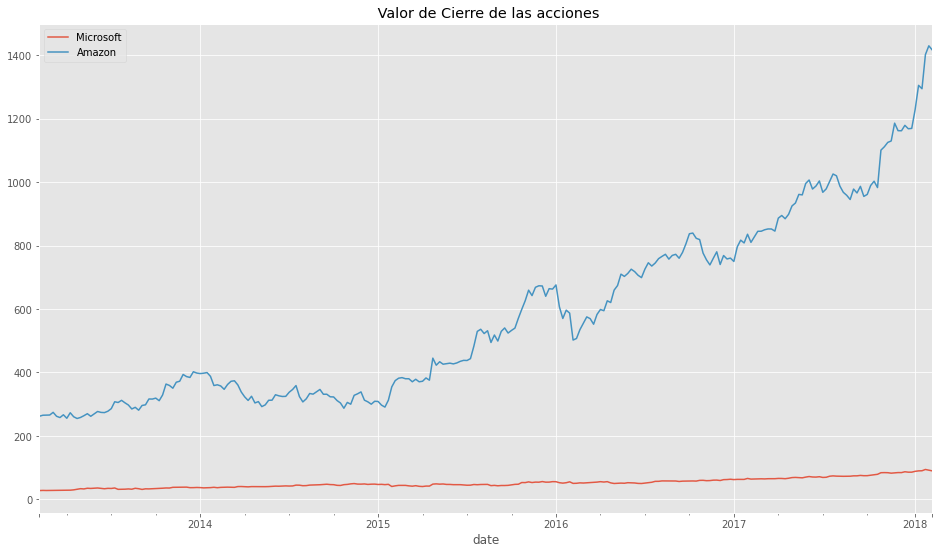

In [ ]:
plot_stock('MSFT')
plot_stock('AMZN')
plt.title(' Valor de Cierre de las acciones')
plt.legend();

###Calcular los rendimientos para que podamos comparar las acciones

---
Calcularemos la devolución desde el primer día de la compra. Por lo tanto, el rendimiento de un día determinado es cuánto se ganaría (o perdería), en porcentaje, si las acciones se vendieran en este día (los costos de transacción no se consideran)


In [ ]:
#df_acciones.head()
start = df_acciones.iloc[0]  #traemos la primera fila y la volvemos un vector
#calculamos el valor del retorno de la acción
returns = (df_acciones - start) / start
returns

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-02-17,-0.062777,-0.016949,0.001267,-0.031201,0.036690,-0.006185,0.019471,0.011595,-0.012398,0.010394,...,0.015227,0.016262,-0.002821,-0.001633,0.001256,0.043928,-0.020061,0.000659,0.008285,0.028139
2013-02-24,-0.072760,-0.080000,0.003929,-0.050886,0.060966,0.001280,0.004069,0.020325,-0.014571,-0.003939,...,0.026558,0.011997,0.006658,-0.025426,0.020101,0.025840,0.002297,-0.022544,-0.004143,-0.013918
2013-03-03,-0.069876,-0.077288,-0.032066,-0.093708,0.043034,0.023246,-0.023540,0.020597,0.018149,-0.010284,...,0.020538,-0.022927,0.009254,-0.039888,0.023869,0.014766,-0.001378,-0.011338,-0.004143,0.046899
2013-03-10,-0.045475,0.011525,-0.026109,-0.091078,0.030069,0.033909,0.007847,0.068749,0.060838,0.007659,...,0.050283,0.022927,0.004063,-0.003032,0.094221,0.049465,0.037060,-0.005933,0.048053,0.031467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-14,0.591171,2.964068,0.469455,1.609861,1.768000,1.111324,0.709968,1.184013,3.985941,1.013567,...,0.256728,0.990403,-0.012301,0.534640,0.029209,1.600960,0.280551,0.609756,1.207125,1.281089
2018-01-21,0.620896,2.936271,0.483143,1.630051,1.886621,1.133930,0.723627,1.206384,4.003323,1.103720,...,0.255312,1.018395,-0.016477,0.445066,-0.001256,1.654485,0.283461,0.627950,1.225766,1.318306
2018-01-28,0.659716,2.597966,0.567047,1.527625,2.398897,1.249520,0.843069,1.217296,4.145706,1.053392,...,0.298513,0.917889,0.004401,0.465827,0.031093,1.746770,0.320061,0.664206,1.237780,1.423298


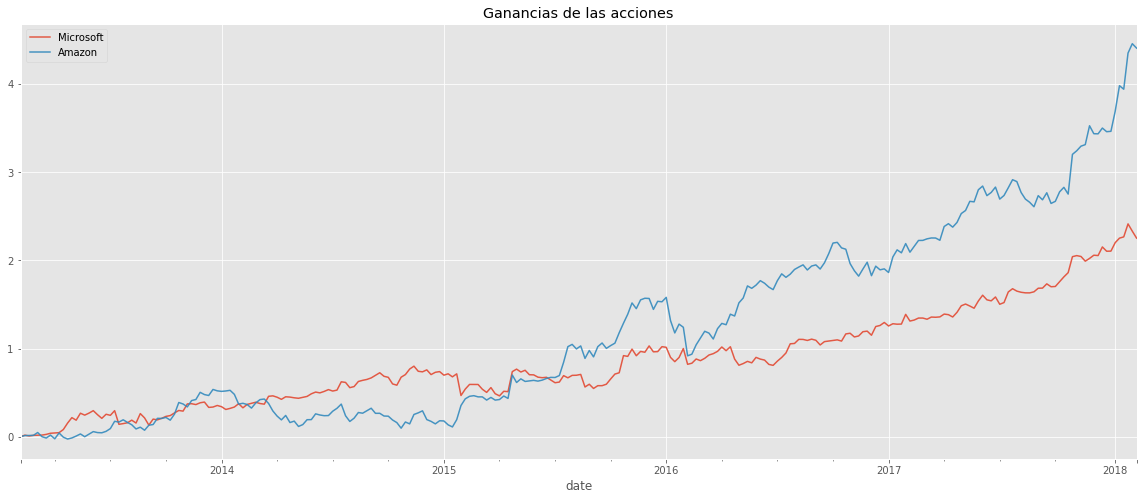

In [ ]:
plt.figure(figsize = (20,8))
plot_stock('MSFT', df_acciones=returns)
plot_stock('AMZN', df_acciones=returns)
plt.title('Ganancias de las acciones')
plt.legend();

#DATOS DE MERCADEO DE VALORES (Acciones de Amazon)

---
Vamos a aplicar el algoritmo sobre un conjunto de datos de las acciones de Samsung en bolsa de Estados unidos, donde bucaremos :


*   la señal CLOSE (precio de cierre diario) 
*   la señal VOLUME (número de acciones que han cambiado de manos a lo largo de dicho período de tiempo).


https://es-us.finanzas.yahoo.com/


##Importando librerías

In [89]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing  #para normalizar los datos antes de aplicar al algoritmo
from sklearn.metrics import pairwise_distances_argmin_min

import matplotlib.pyplot as plt
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D

#configuraciones basicas para PLT
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

##importando dataset

In [90]:
df = pd.read_csv("https://raw.githubusercontent.com/mairapineda/Deep_Learning/main/AMZN.csv")
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-15,854.330017,854.450012,847.109985,852.969971,852.969971,2562200
1,2017-03-16,855.299988,855.500000,850.510010,853.419983,853.419983,1842300
2,2017-03-17,853.489990,853.830017,850.640015,852.309998,852.309998,3384400
3,2017-03-20,851.510010,857.799988,851.010010,856.969971,856.969971,2282700
4,2017-03-21,858.840027,862.799988,841.309998,843.200012,843.200012,4382900


## conociendo y Preprocesando los datos


In [91]:
#df.describe()
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

###Normalización de los datos.

---
Como ocurre con cualquier algoritmo de Machine Learning que utilice funciones de distancia, los datos deben ser normalizados antes de aplicarles el algoritmo. En este caso utilizaremos la función MinMaxScaler() que normaliza todos los datos entre [0, 1].


###Eliminando columnas que no necesitaremos (por ahora)

---
extraemos la columna DATE (fecha) que no usaremos en el algoritmo k-means. Antes de extraerla la guardaremos en la variable dates, ya que volveremos a insertarla en nuestro dataframe tras aplicar el algoritmo


In [92]:
df = df.dropna()
df = df.reset_index(drop=True)

In [93]:
# Eliminamos columna de fecha que no usaremos en el algoritmo.
dates = df['Date'] # Guardamos la columna Date.
df = df.drop('Date', 1) # Borramos la columna del dataframe.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


###Normalización de los datos.

---
Como ocurre con cualquier algoritmo de Machine Learning que utilice funciones de distancia, los datos deben ser normalizados antes de aplicarles el algoritmo. En este caso utilizaremos la función MinMaxScaler() que normaliza todos los datos entre [0, 1].


In [94]:
#%% Se normalizan los datos con MinMax()
min_max_scaler = preprocessing.MinMaxScaler() 
df_escalado = min_max_scaler.fit_transform(df)
df_escalado = pd.DataFrame(df_escalado) # Hay que convertir a DF el resultado.
df_escalado = df_escalado.rename(columns = {0: 'Close', 1: 'Volume'})

In [95]:
df_escalado.head()
df_escalado.isnull().sum()

Close     0
Volume    0
2         0
3         0
4         0
5         0
dtype: int64

###Representación gráfica de los datos.

---


*   Ahora podemos echar un vistazo a la representación gráfica de nuestros datos. En el eje x representaremos el precio de cierre (CLOSE) y en el eje y el volumen (VOLUMEN)
*   VAMOS A representar gráficamente los datos normalizados, pero que, si hubiésemos representado los datos sin normalizar la gráfica sería exactamente igual, con la única diferencia que la escala de los ejes sería diferente.





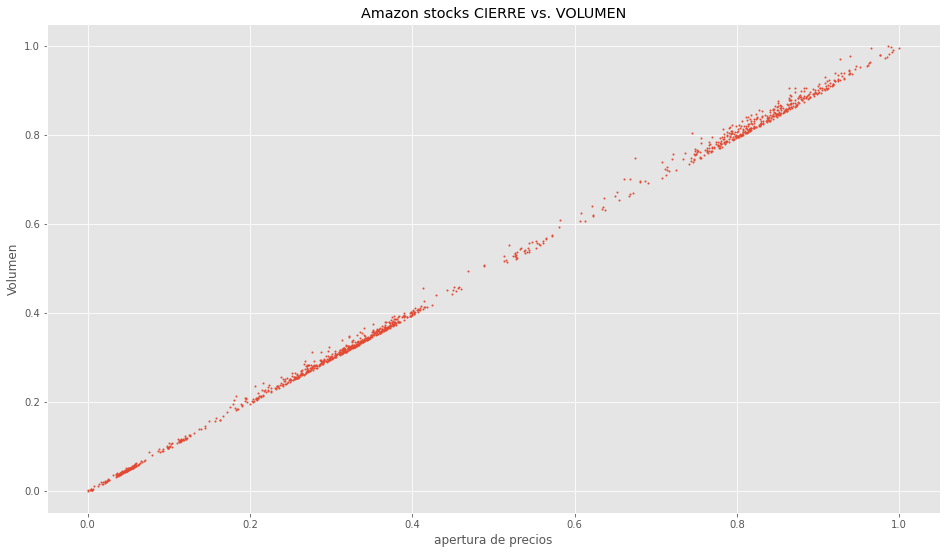

In [96]:
#%% Representación gráfica de los datos.
x = df_escalado['Close'].values
y = df_escalado['Volume'].values
plt.xlabel('apertura de precios')
plt.ylabel('Volumen')
plt.title('Amazon stocks CIERRE vs. VOLUMEN')
plt.plot(x,y,'o',markersize=1)

##Aplicación de k-means.

---
El primer paso antes de aplicar k-means es decidir qué valor de k (número de clústeres) queremos usar:


1.    Una forma de elegir este valor k es por criterio propio: si conocemos bien la distribución de nuestros datos y queremos “forzar” un número determinado de clústeres simplemente lo elegimos
2.    realizar una gráfica elbow o de codo para determinar el número óptimo de clústeres. Hacemos una iteración de k-means variando el valor de k, de forma que representamos en el eje x dicho valor de k y en el eje y la suma de los errores cuadráticos (SSE). De esta forma podemos elegir el valor de k dónde se produce el “codo”   (**----ESTA ME GUSTA MÁS---**)




###Realizar una gráfica elbow o de codo

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

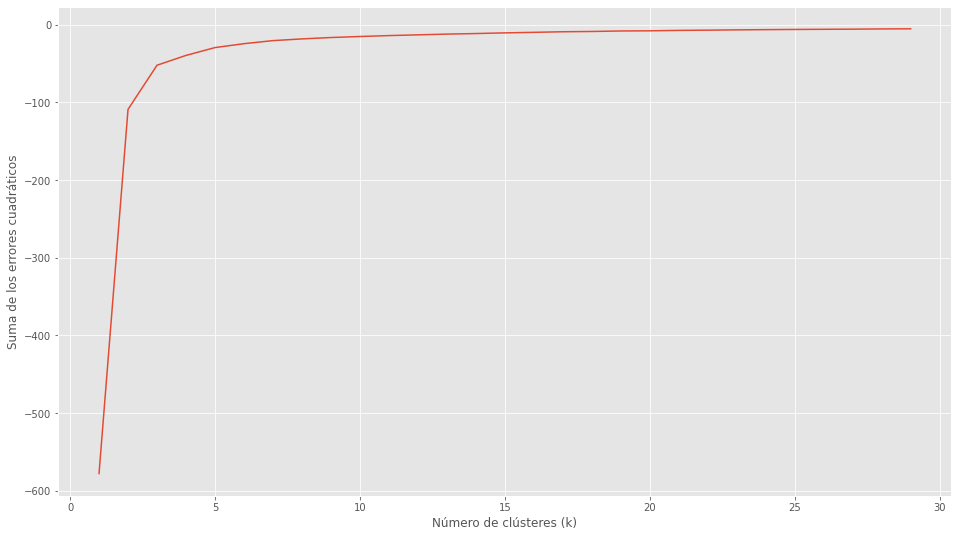

In [97]:
#%% Curva elbow para determinar valor óptimo de k.
nc = range(1, 30) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(df_escalado).score(df_escalado) for i in range(len(kmeans))]
score
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

####NOTA: 

---


**No hay una solución, un valor de k, más correcto que otro**, ya que el objetivo de una clusterización con k-means es obtener información útil nuestros datos, por lo que **nuestra interpretación a posteriori de los clústeres creados marcará la calidad de nuestra solución** escogida

###Aplicar el algoritmo de k-mean

In [98]:
#%% Aplicación de k-means con k = 5.
kmeans = KMeans(n_clusters=5).fit(df_escalado)
centroids = kmeans.cluster_centers_
print(centroids)   #coordenadas de los centroides

[[0.83943439 0.84276862 0.83915733 0.84157469 0.84157469 0.18704138]
 [0.06150582 0.05958661 0.06124549 0.0601233  0.0601233  0.16111275]
 [0.3360236  0.33518003 0.33690985 0.33645585 0.33645585 0.19154258]
 [0.2505388  0.25459299 0.24419138 0.2492955  0.2492955  0.44449656]
 [0.58868355 0.59400971 0.58514364 0.58997589 0.58997589 0.25555675]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


###Etiquetado de datos.

---
asignamos cada registro de nuestro dataset a uno de los clústers


In [99]:
#%% Etiquetamos nuestro dataframe.
labels = kmeans.predict(df_escalado)   #generamos las etiquetas de cada clouster
df['label'] = labels                   #añadimos la columna “label” a nuestro dataframe original

df.insert(0, 'Date', dates)           #%% Añadimos la columna de fecha

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [100]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,label
0,2017-03-15,854.330017,854.450012,847.109985,852.969971,852.969971,2562200,1
1,2017-03-16,855.299988,855.500000,850.510010,853.419983,853.419983,1842300,1
2,2017-03-17,853.489990,853.830017,850.640015,852.309998,852.309998,3384400,1
3,2017-03-20,851.510010,857.799988,851.010010,856.969971,856.969971,2282700,1
4,2017-03-21,858.840027,862.799988,841.309998,843.200012,843.200012,4382900,1
5,2017-03-22,840.429993,849.369995,839.049988,848.059998,848.059998,2658700,1
6,2017-03-23,848.200012,850.890015,844.799988,847.380005,847.380005,1953000,1
7,2017-03-24,851.679993,851.799988,843.530029,845.609985,845.609985,2138300,1
8,2017-03-27,838.070007,850.299988,833.500000,846.820007,846.820007,2755800,1
9,2017-03-28,851.750000,858.460022,850.099976,856.000000,856.000000,3041600,1


##Representación gráfica de los clústeres k-means.

---
Una vez con los datos etiquetados, podemos visualizar gráficamente en dos dimensiones el clustering realizado por k-means, ya que hemos usado sólo dos variable


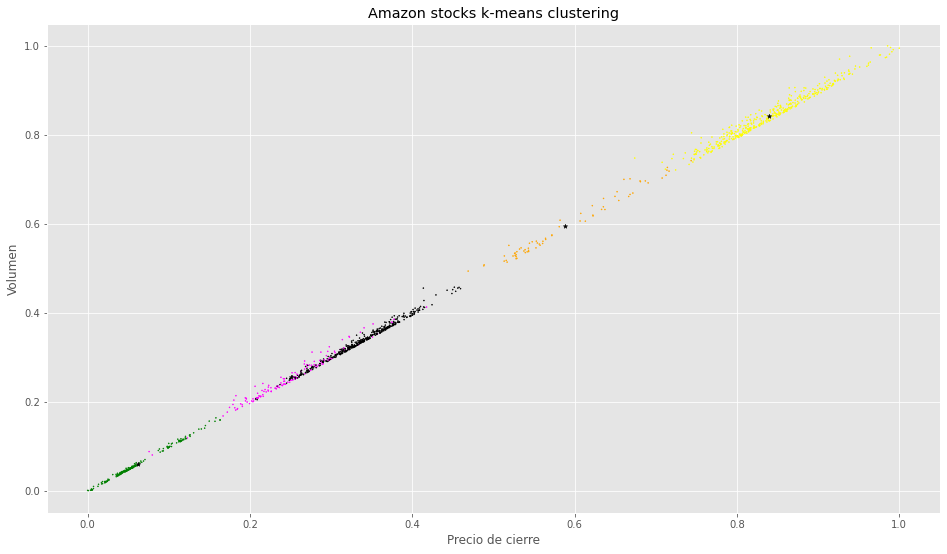

In [101]:
#%% Plot k-means clustering.
colores=['yellow','green','black','fuchsia','orange']
asignar=[]
for row in labels:
     asignar.append(colores[row])
plt.scatter(x, y, c=asignar, s=1)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='black', s=20) # Marco centroides.
plt.xlabel('Precio de cierre')
plt.ylabel('Volumen')
plt.title('Amazon stocks k-means clustering')
plt.show()

##Clasificación de nuevas muestras.

---
Supongamos que nuestros nuevos datos a categorizar son los siguientes:


*   CLOSE: 100.000
*   VOLUME: 5.500.000






### Agregando datos de forma clasica (paso a paso)

In [102]:
close = 100000
volume = 5500000

nuevo_dato = pd.DataFrame([[close,volume]]) # Nueva muestra
nuevo_dato = nuevo_dato.rename(columns = {0: 'Close', 1: 'Volume'})

#### Normalizamos los nuevos datos

In [103]:
#agregamos los datos al dataframe original
df_n = df.append(nuevo_dato)

####borramos columnas que no tenemos

---

Nuestro nuevo dataframe df_n tiene aun las columnas “date” y “label” del datafame original, así que las eliminamos y resetamos el índice

In [104]:
df_n = df_n.drop('Date', 1)
df_n = df_n.drop('label', 1)
df_n = df_n.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


####Aplicamos normalización de datos [0 - 1]

In [105]:
min_max_scaler = preprocessing.MinMaxScaler() 
df_escalado = min_max_scaler.fit_transform(df_n)
df_escalado = pd.DataFrame(df_escalado) # Hay que convertir a DF el resultado.
df_escalado = df_escalado.rename(columns = {0: 'Close', 1: 'Volume'})

In [108]:
df_escalado.iloc[-3:]   #ver los ultimos registros

,Close,Volume,2,3,4,5
1257,0.741043,0.733359,0.724300,0.020849,0.715769,0.163176
1258,0.716311,0.718139,0.692972,0.020108,0.690345,0.179996
1259,NaN,NaN,NaN,1.000000,NaN,0.294490
